In [24]:
import json
import os
import random
from typing import List

import cv2
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    DatasetMapper,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer

# Prepare Dataset

In [2]:
import torch
from torch.utils.data import random_split
import shutil


def cp_files(file_list: List[str], destination: str):
    for f in file_list:
        shutil.copyfile(f, os.path.join(destination, os.path.split(f)[-1]))


def move_train_test(
    img_dir: str,
    annotation_filename: str = "annotation-bh.json",
    train_split: float = 0.8,
):
    annotation_json = os.path.join(img_dir, annotation_filename)
    dataset_filenames = []
    with open(annotation_json, "r") as f:
        data = json.load(f)
        img_annotations = data["_via_img_metadata"]
    for k, image in img_annotations.items():
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        dataset_filenames.append({k: image})
    train_size = int(train_split * len(dataset_filenames))
    test_size = len(dataset_filenames) - train_size
    train_dataset_files, test_dataset_files = random_split(
        dataset_filenames,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42),
    )
    train_dataset_filenames = [
        os.path.join(img_dir, values["filename"])
        for f in train_dataset_files
        for values in f.values()
    ]
    test_dataset_filenames = [
        os.path.join(img_dir, values["filename"])
        for f in test_dataset_files
        for values in f.values()
    ]
    os.makedirs(os.path.join(img_dir, "train"), exist_ok=True)
    os.makedirs(os.path.join(img_dir, "test"), exist_ok=True)
    cp_files(train_dataset_filenames, os.path.join(img_dir, "train"))
    cp_files(test_dataset_filenames, os.path.join(img_dir, "test"))
    with open(os.path.join(img_dir, "train", annotation_filename), "w") as f:
        data["_via_img_metadata"] = {
            k: v for f in train_dataset_files for k, v in f.items()
        }
        json.dump(data, f)
    with open(os.path.join(img_dir, "test", annotation_filename), "w") as f:
        data["_via_img_metadata"] = {
            k: v for f in test_dataset_files for k, v in f.items()
        }
        json.dump(data, f)


move_train_test("cv-bh-data")

# Setup

In [2]:
from detectron2.structures import BoxMode


def create_dataset_dicts(
    img_dir: str, annotation_filename: str = "annotation-bh.json"
) -> List[dict]:
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        img_annotations = json.load(f)["_via_img_metadata"]
    dataset = []
    for id, image in enumerate(img_annotations.values()):
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        record = {}
        image_filename = os.path.join(img_dir, image["filename"])
        height, width = cv2.imread(image_filename).shape[:2]

        # Create dataset dict according to detectron2 dataset specification
        # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts

        record["file_name"] = image_filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = id

        annotation_objects = []
        for annotation in image["regions"]:
            anno = annotation["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            # Merge point lists and flatten to [x_1, y_1, ..., x_n y_n] format
            polygons = [(x, y) for (x, y) in zip(px, py)]
            polygons = np.ravel(polygons).tolist()
            annotation_obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [polygons],
                "category_id": 0,  # We only have one category
            }
            annotation_objects.append(annotation_obj)
        record["annotations"] = annotation_objects
        dataset.append(record)
    return dataset

In [3]:
def create_train_augmentations(cfg):
    augs = [
        T.RandomCrop("relative", (0.5, 0.5)),
        T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, sample_style="choice"),
        T.RandomRotation(5),
        T.RandomBrightness(0.85, 1.15),
        T.RandomContrast(0.85, 1.15),
        T.RandomFlip(vertical=False),
    ]
    return augs

In [3]:
for dataset_type in ["train", "test"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"cv-bh-data/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold"]
hold_metadata_train = MetadataCatalog.get("hold_train")
hold_metadata_test = MetadataCatalog.get("hold_test")

In [4]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)
cfg.DATASETS.TRAIN = ("hold_train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300
cfg.SOLVER.STEPS = []
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512

# Train Model

In [10]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(
            cfg, is_train=True, augmentations=create_train_augmentations(cfg)
        )
        return build_detection_train_loader(cfg, mapper=mapper)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

# Test Model

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # confidence threshold for testing
cfg.DATASETS.TEST = ("hold_test",)
predictor = DefaultPredictor(cfg)

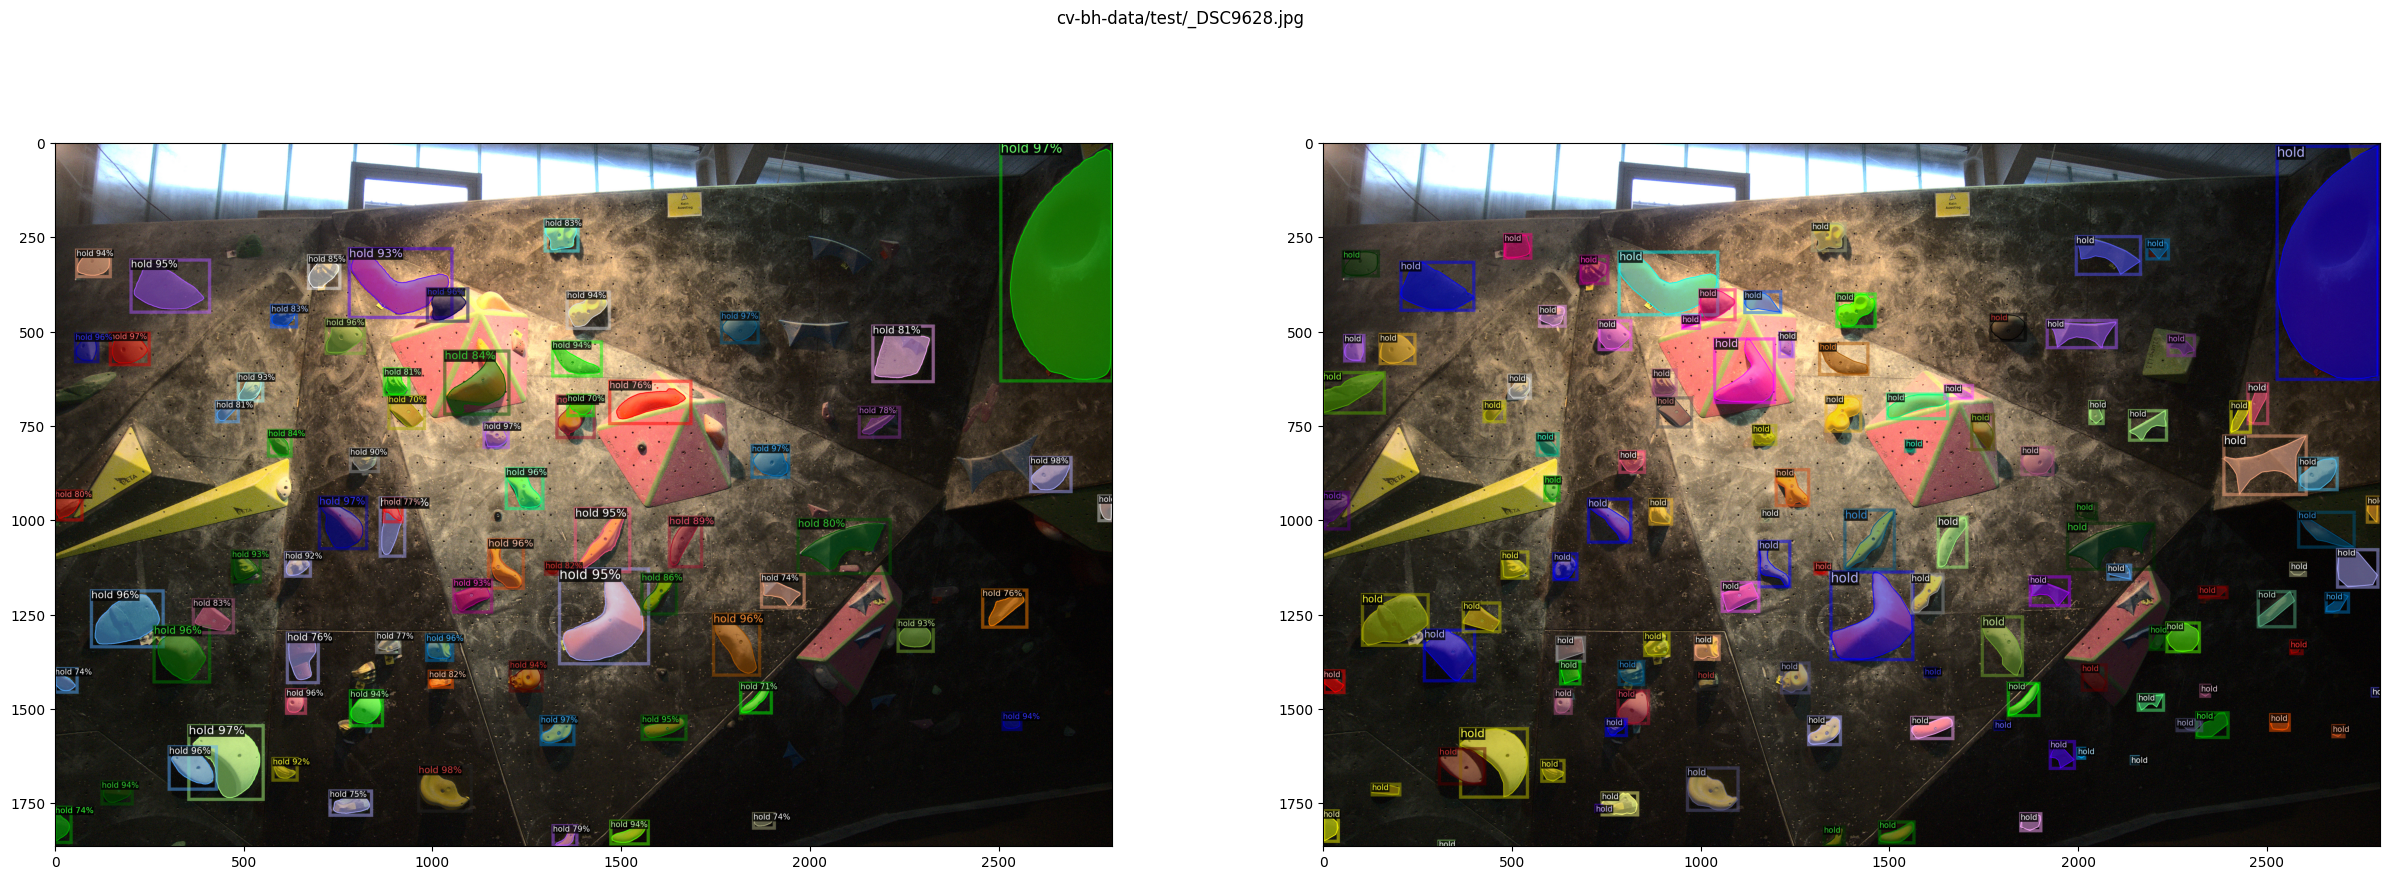

In [23]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = create_dataset_dicts("cv-bh-data/test")
for d_dict in random.sample(dataset_dicts, 1):
    im = cv2.imread(d_dict["file_name"])
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=hold_metadata_test,
        scale=0.5,
        # instance_mode=ColorMode.IMAGE_BW
    )
    out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    v = Visualizer(
        im[:, :, ::-1],
        metadata=hold_metadata_test,
        scale=0.5,
        # instance_mode=ColorMode.IMAGE_BW
    )
    out_ground_truth = v.draw_dataset_dict(d_dict)
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    fig.suptitle(d_dict["file_name"])
    ax[0].imshow(out_predictions.get_image())
    ax[1].imshow(out_ground_truth.get_image())
    fig.savefig("comparison.jpg", bbox_inches="tight")

In [7]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator("hold_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "hold_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.511
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.075
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.262
 Average Recall     (AR) @[ IoU=0.50:0.